In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocesslib import preprocessEach, makeY

In [2]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

In [3]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [4]:
xGrowths = bootstrap(xValues, xGrowths)
xOverlaps = bootstrap(xValues, xOverlaps)

In [5]:
#make y values
yGrowths = makeY('growth', len(xGrowths))
yValues = makeY('value', len(xValues))
yOverlaps = makeY('overlap', len(xOverlaps))

In [6]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [7]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [8]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [10]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [11]:
x_train.shape #2570 data samples, 1248 days, 6 features

(2570, 1248, 6)

## Baseline model

In [12]:
from tensorflow.keras.layers import SimpleRNN

In [17]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1248, 6)))
model.add(Dense(8))
model.add(Dense(2, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model1.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1248      
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,530
Trainable params: 1,530
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit(x_train, y_train, epochs=2000, validation_split=0.2, callbacks=[es,mc])

Epoch 1/2000
65/65 [==============================] - 8s 106ms/step - loss: 0.6346 - acc: 0.5720 - val_loss: 0.6137 - val_acc: 0.6206
Epoch 2/2000
65/65 [==============================] - 7s 101ms/step - loss: 0.6220 - acc: 0.5900 - val_loss: 0.6040 - val_acc: 0.5700
Epoch 3/2000
65/65 [==============================] - 7s 101ms/step - loss: 0.6160 - acc: 0.5900 - val_loss: 0.6079 - val_acc: 0.6576
Epoch 4/2000
65/65 [==============================] - 7s 102ms/step - loss: 0.6130 - acc: 0.6036 - val_loss: 0.5985 - val_acc: 0.5798
Epoch 5/2000
65/65 [==============================] - 7s 102ms/step - loss: 0.6259 - acc: 0.5768 - val_loss: 0.6262 - val_acc: 0.6673
Epoch 6/2000
65/65 [==============================] - 7s 102ms/step - loss: 0.6215 - acc: 0.6085 - val_loss: 0.6080 - val_acc: 0.5953
Epoch 7/2000
65/65 [==============================] - 7s 103ms/step - loss: 0.6172 - acc: 0.5934 - val_loss: 0.6093 - val_acc: 0.6148
Epoch 8/2000
65/65 [==============================] - 7s 104ms

In [24]:
import json

history_dict = history.history
with open('history1.json', 'w') as f:
    json.dump(history_dict, f)

In [25]:
# with open('history1.json', 'r') as f:
#     loaded_history_dict = json.load(f)

In [20]:
count_10 = np.sum((y_test == [1, 0]).all(axis=1))
count_01 = np.sum((y_test == [0, 1]).all(axis=1))
count_11 = np.sum((y_test == [1, 1]).all(axis=1))

print(f"[1, 0]의 개수: {count_10}")
print(f"[0, 1]의 개수: {count_01}")
print(f"[1, 1]의 개수: {count_11}")

[1, 0]의 개수: 210
[0, 1]의 개수: 203
[1, 1]의 개수: 230


In [23]:
best_model=load_model('best_model1.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

21/21 [==============================] - 1s 28ms/step


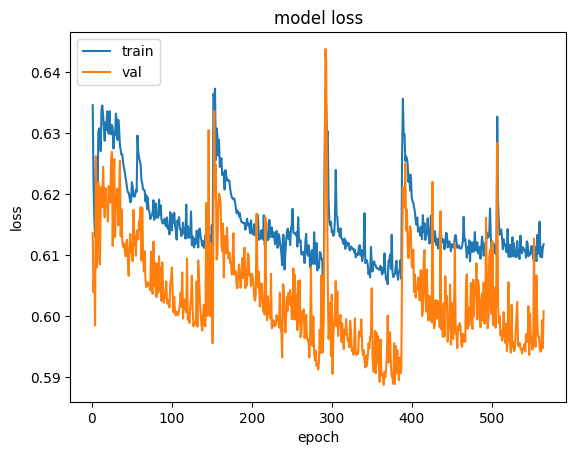

In [21]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

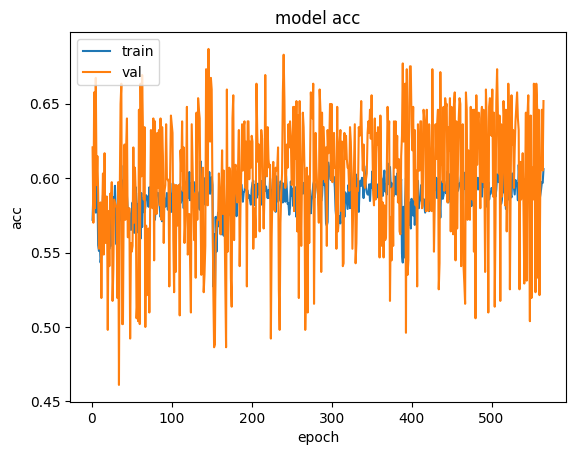

In [22]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()